In [1]:
import csv
import numpy as np
import pandas as pd
from haversine import haversine, Unit

In [2]:
def load_coordinates(filename):
    with open(filename) as f:
        reader = csv.reader(f)
        next(reader)
        return np.array([[float(row[1]), float(row[2])] for row in reader])
        

In [3]:
def load_distances(file_path):
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        distances = [[float(value) for value in row] for row in reader]
    return np.array(distances)

# Refinamento do algoritmo greedy com 2-otp

In [4]:
def greedy_tsp(distances, qtd_matrix):
    # Número total de nós no problema
    num_nodes = len(distances)
    # Lista para manter controle dos nós visitados
    visited = [False] * num_nodes
    # Inicia o caminho com o primeiro nó e marca como visitado
    path = [227]
    visited[227] = True
    # Inicializa a distância e o tempo total
    dist = 0
    time = 0

    # Constrói o caminho visitando todos os nós
    for _ in range(1, num_nodes):
        last = path[-1]
        # Encontra o próximo nó com a menor distância não visitado
        next_node = min(
            [(i, dist) for i, dist in enumerate(distances[last]) if not visited[i]],
            key=lambda x: x[1]
        )[0]
        # Atualiza a distância e o tempo total com o custo para o próximo nó
        dist += distances[last][next_node]
        time += distances[last][next_node] / 5 + (2 / 60) * qtd_matrix[last]
        # Marca o próximo nó como visitado e adiciona ao caminho
        visited[next_node] = True
        path.append(next_node)

    # Aplica a otimização 2-opt ao caminho encontrado para melhorar a solução
    path, dist, time = two_opt(path, distances, qtd_matrix)

    # Retorna o caminho final, a distância total e o tempo total
    return {'sequence': path, 'distance': dist, 'time': time}

def two_opt(path, distances, qtd_matrix, max_iterations=100):
    # Flag para controlar se houve melhoria no caminho
    improved = True
    # Contador para controlar o número de iterações
    iteration_count = 0

    # Loop continua enquanto houver melhoria e o número de iterações for menor que o máximo
    while improved and iteration_count < max_iterations:
        improved = False
        # Testa todas as possíveis trocas de segmentos não consecutivos
        for i in range(1, len(path) - 2):
            for j in range(i + 1, len(path) - 1):
                if j - i == 1:  # Ignora se i e j são consecutivos
                    continue
                # Verifica se a troca resulta em uma distância menor
                if distances[path[i - 1]][path[i]] + distances[path[j]][path[j + 1]] > distances[path[i - 1]][path[j]] + distances[path[i]][path[j + 1]]:
                    # Realiza a troca invertendo o segmento
                    path[i:j + 1] = path[i:j + 1][::-1]
                    improved = True

        # Incrementa o contador de iterações
        iteration_count += 1

    # Recalcula distância e tempo após a otimização 2-opt
    dist = 0
    time = 0
    for k in range(1, len(path)):
        dist += distances[path[k - 1]][path[k]]
        time += distances[path[k - 1]][path[k]] / 5 + (2 / 60) * qtd_matrix[path[k - 1]]

    # Retorna o caminho otimizado, a distância total e o tempo estimado
    return path, dist, time


# Teste do 2-otp

In [5]:
data = pd.read_csv('../../clusterizacao/dados_tratados_clusterizados_10_10.csv')
data.columns

Index(['Unnamed: 0', 'INDICE', 'LATITUDE', 'LONGITUDE', 'CODIGO_ROTA',
       'SEQUENCIA', 'LOGRADOURO', 'NUMERO', 'COMPLEMENTO',
       'QUANTIDADE_HIDROMETROS', 'cluster_leiturista', 'cluster_dia'],
      dtype='object')

In [6]:
# Carrega os dados
data = pd.read_csv('../../clusterizacao/dados_tratados_clusterizados_10_10.csv')
grouped = data.groupby('cluster_leiturista')
solutions = []

for _, group in grouped:
    clusters = group.groupby('cluster_dia')
    solution_leiturista = []

    for label, cluster in clusters:
        coords = cluster[['LATITUDE', 'LONGITUDE']].to_numpy()
        n = len(coords)
        distance_matrix = np.zeros((n, n))
        qtd_matrix = cluster['QUANTIDADE_HIDROMETROS'].values
        for i in range(n):
            for j in range(i + 1, n):
                distance_matrix[i, j] = distance_matrix[j, i] = haversine(coords[i], coords[j], unit=Unit.KILOMETERS)

        solution = greedy_tsp(distances=distance_matrix, qtd_matrix=qtd_matrix)
        solution_leiturista.append({f"sequence_dia_{cluster['cluster_dia'].values[0]}": solution['sequence'],
                                    f"distance_dia_{cluster['cluster_dia'].values[0]}": solution['distance'],
                                    f"tempo_dia_{cluster['cluster_dia'].values[0]}": solution['time']})
    solutions.append({f"leiturista{group['cluster_leiturista'].values[0]}": solution_leiturista})

# Salva o resultado em um arquivo JSON
pd.DataFrame(solutions).to_json('./tsp_greedy_teste_AMOSTRA_TOTAL2.json', indent=2)

C:\Users\Enzo Bressane\AppData\Local\Temp\ipykernel_8524\2723192916.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(tsp_results))


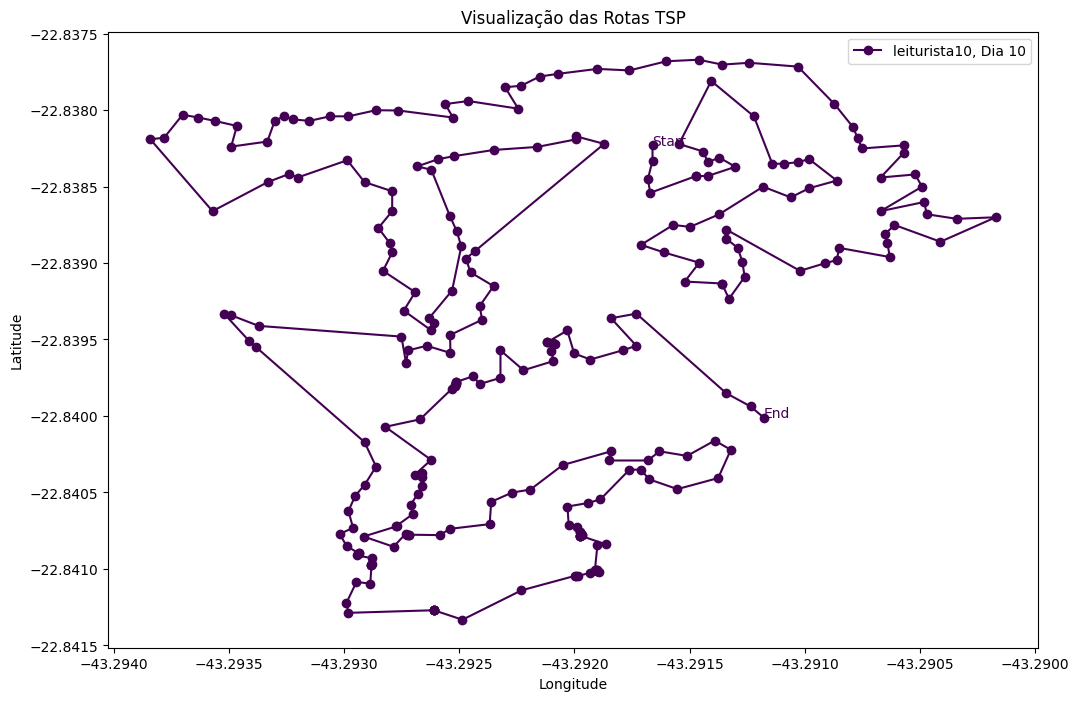

In [7]:
import json
import matplotlib.pyplot as plt

# Carrega os dados originais para obter as coordenadas
data = pd.read_csv('../../clusterizacao/dados_tratados_clusterizados_10_10.csv')

# Carrega o arquivo JSON com os resultados do TSP
with open('./tsp_greedy_teste_AMOSTRA_TOTAL2.json') as file:
    tsp_results = json.load(file)

# Preparar a plotagem
fig, ax = plt.subplots(figsize=(12, 8))

# Gerar uma paleta de cores baseada no número de leituristas
color_map = plt.cm.get_cmap('viridis', len(tsp_results))

for idx, (leiturista, days) in enumerate(tsp_results.items()):
    for day_data in days.values():
        for route in day_data:
            # Extrai os índices das sequências visitadas
            sequence_idx = route['sequence_dia_10']
            # Recupera as coordenadas
            coords = data.loc[sequence_idx, ['LATITUDE', 'LONGITUDE']].values

            # Plotar a rota
            ax.plot(coords[:, 1], coords[:, 0], marker='o', linestyle='-', color=color_map(idx), label=f'{leiturista}, Dia 10')
            ax.text(coords[0, 1], coords[0, 0], 'Start', color=color_map(idx))
            ax.text(coords[-1, 1], coords[-1, 0], 'End', color=color_map(idx))

ax.set_title('Visualização das Rotas TSP')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.show()
